In [ ]:
! pip install pygsp

In [1]:
import networkx as nx
import graphviz
import matplotlib.pyplot as plt
import numpy as np
font = {'size'   : 10}
plt.rc('font', **font)

##  Example 1 - time series graph and the Fourier basis
Displaying the relation between the time-series Laplacian eigen-decomposition
and the Fourier basis

In [31]:
N = 8
G = nx.Graph([(n,n+1) for n in range(N)])
G.edges()

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8)]

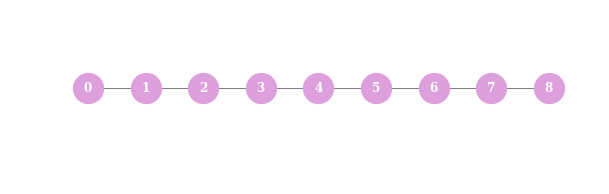

In [32]:
fig = plt.figure(figsize=(10,3))

plt.style.use('seaborn')
# with plt.xkcd():
kw_nx = dict(node_color='Plum', node_size=800
             , alpha=1., linewidths=3
             , edge_color='Gray', edge_alpha=0.1
             , font_family='serif',font_weight=600
             , font_color='w', font_size=12
            )
pos = {n:(k*2,0.5) for k,n in enumerate(G.nodes())}
ax = plt.gca()
nx.draw_networkx(G, pos = pos, **kw_nx)
ax.set_axis_off()
    
plt.show()

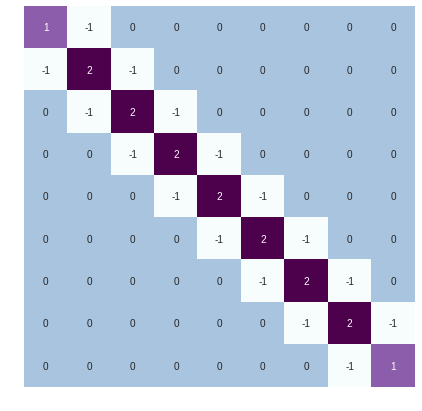

In [33]:
import seaborn as sns
fig = plt.figure(figsize=(7,7))
L = nx.laplacian_matrix(G)
ax=plt.gca()
sns.heatmap(L.toarray(),annot=True, fmt="d", cbar=False,cmap="BuPu")
ax.set_axis_off()
plt.show()

We see that the Laplacian has actually the form of the Discrete Cosine Transform (DCT), which is a variant of Fourier Transform. Thus the Eigenvalues have the following analytical structure
$$\chi_k:j\rightarrow\cos\Big(\big(j+\frac{1}{2}\big)\frac{k\pi}{N}\Big)$$

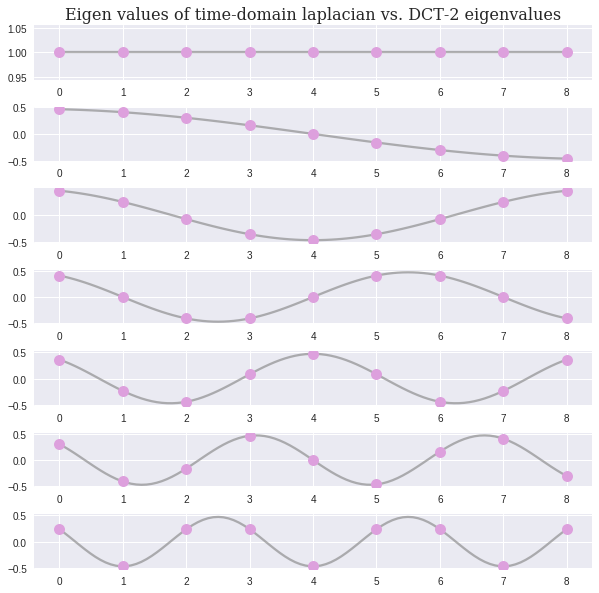

In [34]:
N=9
lambd, chi = np.linalg.eigh(L.toarray())
x = np.linspace(0, N-1,100)
dct2_eigen = lambda l: np.sqrt(2/N) * np.cos(np.pi * l * (x+0.5) / N)

kw_plot_1 = dict(color='Gray',alpha=0.6)
kw_plot_2 = dict(marker='o'
                 , linestyle='None',alpha=1
                 , markerSize=11, markerFaceColor='Plum')
fig,axes = plt.subplots(nrows=N-2, ncols=1, figsize= (10,10), gridspec_kw=dict(hspace=0.5))
# with plt.xkcd():
plt.style.use('seaborn-talk')
for k, eigvec in enumerate(chi.T):
    # scaling the first eigenvector to unit $\mathbf{1}$
    if k==0:
        axes[k].plot(x, np.ones_like(x),**kw_plot_1)
        axes[k].plot(np.ones_like(eigvec), **kw_plot_2)
        axes[k].set_title("Eigen values of time-domain laplacian vs. DCT-2 eigenvalues"
                          , fontsize=16, fontname='serif')
    else:
        axes[k].plot(x, dct2_eigen(k),**kw_plot_1)
        axes[k].plot(eigvec, **kw_plot_2)
    # TODO: bug with k=6 (!?)
    if k > 5:
        break
plt.show()

## Example 2 - Filtering on Minnesota road network

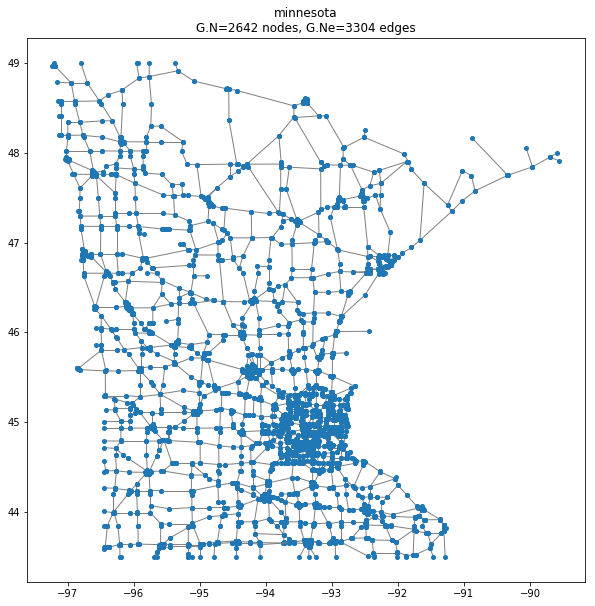

In [15]:
from pygsp import graphs, filters
from pygsp import plotting
import matplotlib.pylab as plt

plt.style.use('seaborn-deep')
fig = plt.figure(figsize= (10,10))
ax = fig.gca()
plottingparam = dict(backend='matplotlib')
G = graphs.Minnesota()
plotting.plot(G,ax = ax,**plottingparam)
plt.show()

In [23]:
G.compute_fourier_basis()

Lets create a noisy signal based on the distance from the dense part of Minnesota, specifically in $(-93.2, 45)$, somewhere next to Hennepin. We added a nonlinear cutoff for $s_{in}>2$ ,to further localize the signal  
Because of the high density and connectivity we assume that this signal corresponds to one of the dominant spectral components, and indeed it seems like the third one

In [3]:
rs = np.random.RandomState()
s = np.zeros(G.N)
s += np.sqrt(np.sum((G.coords - np.array([-93.2, 45]))**2, axis=1))
s[s>2] = 3
s += rs.uniform(-1,1, size=G.N)

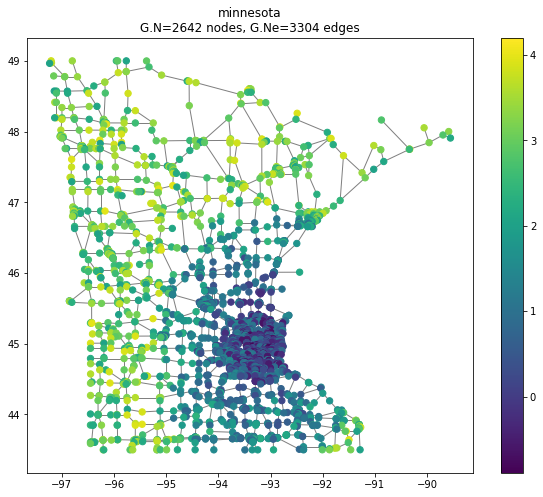

In [4]:
fig = plt.figure(figsize= (10,8))
plt.style.use('seaborn-deep')
ax = fig.gca()
plotting.plot_signal(G,s,ax=ax,**plottingparam)
plt.show()

First lets design a heat filter and visualize it in the spectral domain.
The impulse response of this filter goes by

$$\hat{g}(x) = \exp \left( \frac{-\tau x}{\lambda_{\text{max}}} \right)$$

As you can tell, this is a Low Pass filter. We choose $tau=50$ because we want to assure the removal of higher noise frequencies, and we assume that the spectral components that describe the clean signal have very small eigenvalues. 

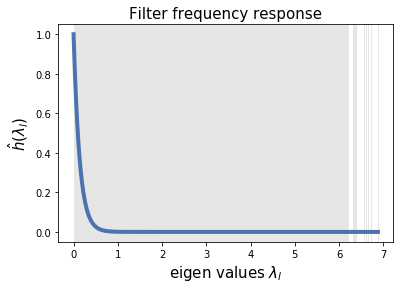

In [48]:
# First design filter as a heat fi
g = filters.Heat(G, tau=50)
fig, ax = plt.subplots(1,1)
g.plot(plot_eigenvalues=True, ax=ax)
ax.set_xlabel("eigen values $\lambda_l$", fontsize=15)
ax.set_ylabel("$\hat{h}(\lambda_l)$", fontsize=15)
ax.set_title('Filter frequency response',fontsize=15)
plt.show()

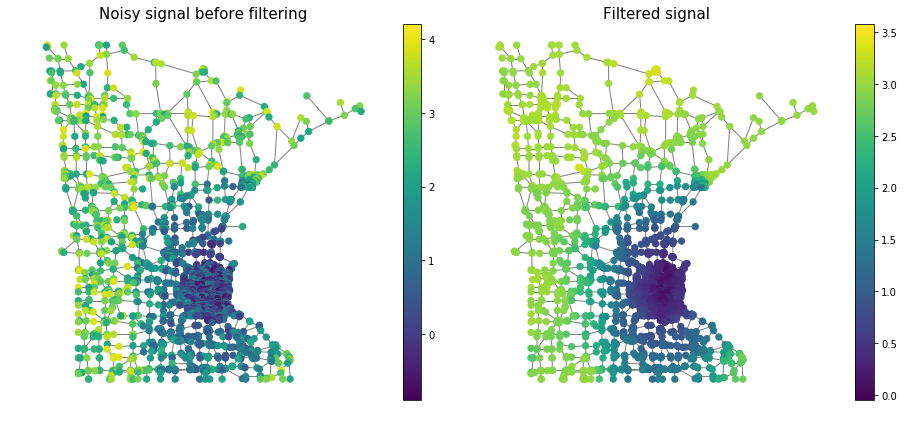

In [50]:
s_out = g.filter(s, method='exact') # exact uses GFT. Chebychev is also available

fig, axes = plt.subplots(1, 2, figsize=(13, 6))
axes[0]
plotting.plot_signal(G, s, ax=axes[0], **plottingparam)
_ = axes[0].set_title('Noisy signal before filtering',fontsize=15)
axes[0].set_axis_off()
plotting.plot_signal(G, s_out, ax=axes[1], **plottingparam)
_ = axes[1].set_title('Filtered signal',fontsize=15)
axes[1].set_axis_off()
fig.tight_layout()
plt.show()

## Draft

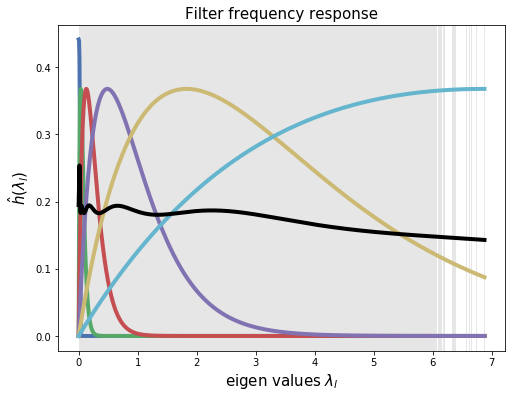

In [35]:
# First design filter as a heat fi
g = filters.MexicanHat(G, Nf=6, lpfactor=100)
fig, ax = plt.subplots(1,1, figsize=(8,6))
g.plot(plot_eigenvalues=True, ax=ax)
ax.set_xlabel("eigen values $\lambda_l$", fontsize=15)
ax.set_ylabel("$\hat{h}(\lambda_l)$", fontsize=15)
ax.set_title('Filter frequency response',fontsize=15)
plt.show()

In [38]:
s_out = g.filter(s, method='exact') # exact uses GFT. Chebychev is also available

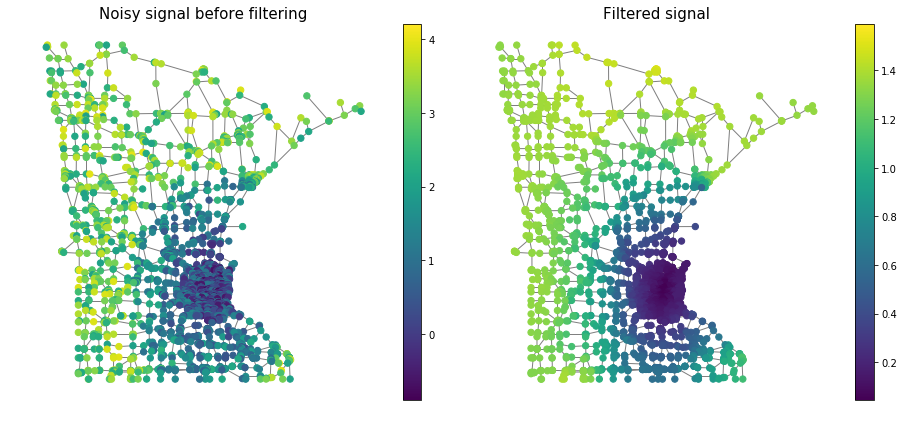

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6))
axes[0]
plotting.plot_signal(G, s, ax=axes[0], **plottingparam)
_ = axes[0].set_title('Noisy signal before filtering',fontsize=15)
axes[0].set_axis_off()
plotting.plot_signal(G, s_out[:,0], ax=axes[1], **plottingparam)
_ = axes[1].set_title('Filtered signal',fontsize=15)
axes[1].set_axis_off()
fig.tight_layout()
plt.show()

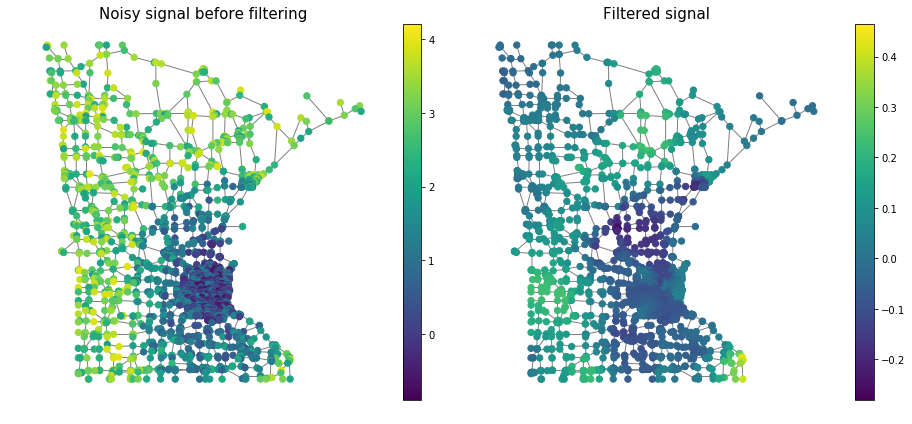

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6))
axes[0]
plotting.plot_signal(G, s, ax=axes[0], **plottingparam)
_ = axes[0].set_title('Noisy signal before filtering',fontsize=15)
axes[0].set_axis_off()
plotting.plot_signal(G, s_out[:,1], ax=axes[1], **plottingparam)
_ = axes[1].set_title('Filtered signal',fontsize=15)
axes[1].set_axis_off()
fig.tight_layout()
plt.show()

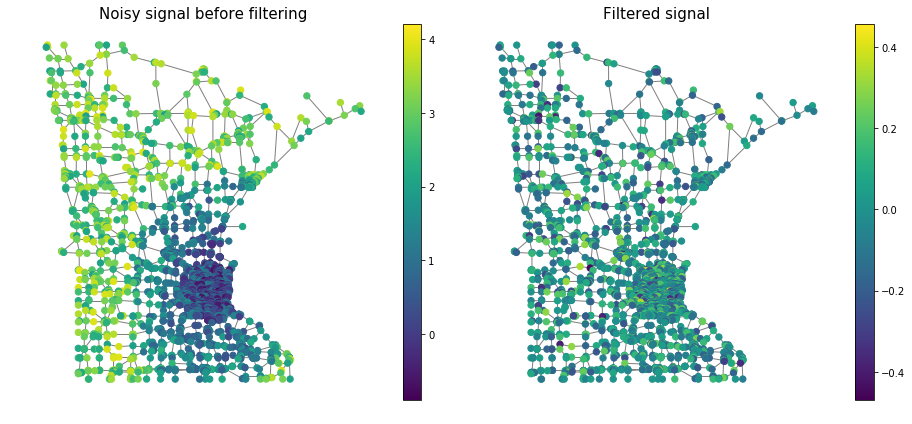

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6))
axes[0]
plotting.plot_signal(G, s, ax=axes[0], **plottingparam)
_ = axes[0].set_title('Noisy signal before filtering',fontsize=15)
axes[0].set_axis_off()
plotting.plot_signal(G, s_out[:,5], ax=axes[1], **plottingparam)
_ = axes[1].set_title('Filtered signal',fontsize=15)
axes[1].set_axis_off()
fig.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize= (10,8))
s = G.U[:,2]
plt.style.use('seaborn-paper')
ax = fig.gca()
plotting.plot_signal(G,s,ax=ax,**plottingparam,)
plt.show()

Now lets design the new signal as a combination of some noise, and the 1,3 and 7 spectral components

In [287]:
N = G.coords.shape[0]
s_hat_in = G.U.dot(np.ones((N,1)))
filt_fun = lambda e_val: np.exp(-2*e_val)
# inverse graph fourier transform on s_hat_in
s_hat_out = s_hat_in.T.dot((G.U.T * filt_fun(G.e)))

# sigma = 0.2
# coeff = np.array([1,3,2,5])
# s_hat_out = G.U[:,range(0,8,2)].dot(coeff.T) + sigma * np.random.randn(G.U.shape[0])

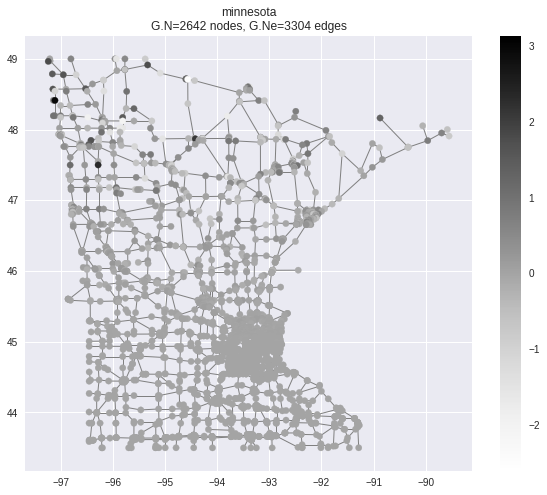

In [278]:
fig = plt.figure(figsize= (10,8))
ax = fig.gca()
plotting.plot_signal(G,s_hat_out,**plottingparam,ax=ax)
plt.show()

Let's first late a look on the spectrum.

In [ ]:
sigma = 0.2
coeff = np.array([1,3,2,5])
s_hat_out = G.U[:,range(0,8,2)].dot(coeff.T) + sigma * np.random.randn(G.U.shape[0])

The [Fiedler vector](https://en.wikipedia.org/wiki/Algebraic_connectivity) enables to partition the graph, and thus we expect one of the prime spectral component's to segregate the dense part from the rest of the map. 
Let's filter the signal to it's low frequencies

In [388]:
s_in = s_hat_out
s_hat_in = s_in.dot(G.U).T
s_filt = pygsp.filters.cheby_rect(G, [0.0015,0.0025],s_hat_in,order=150)
# s_filt = pygsp.filters.MexicanHat(G, [0.0015,0.0025],s_hat_in,order=150)
# s_filt = g.filter(s_in.T)

In [384]:
fig = plt.figure(figsize= (8,6))
ax = fig.gca()
G.plot_signal(s_filt[:,5], ax=ax, **plottingparam)
plt.show()

KeyboardInterrupt: 

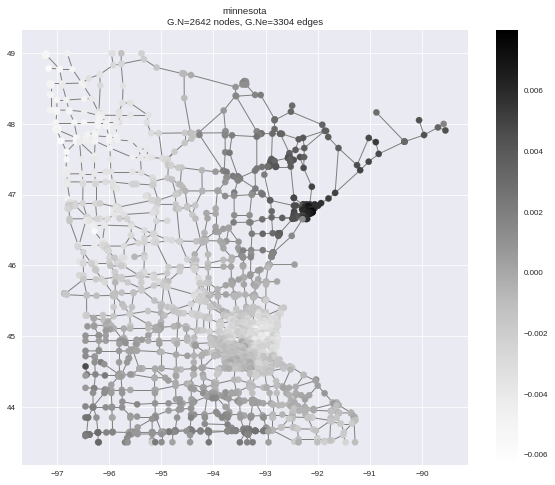

In [389]:
fig = plt.figure(figsize= (10,8))
ax = fig.gca()
# plotting.plot_signal(G,G.U[:,2],**plottingparam,ax=ax)
plotting.plot_signal(G,s_filt,**plottingparam,ax=ax)
plt.show()

# std = 0.0001
# filt_fun = lambda e_val: np.exp( (e_val - G.e[2])**2/std)
# # inverse graph fourier transform on s_hat_in
# s_hat_out = s_hat_in.T.dot((G.U.T * filt_fun(G.e)))